# RL CartPole: Simple DQN

In [1]:
import numpy as np
import gym
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam


Observation space: (8,) n_actions: 4
Episode: 0,Total Reward: -325.0764935005817, Mean Reward: -325.0764935005817, epsilon: 1
Episode: 1,Total Reward: -461.42287756476964, Mean Reward: -393.2496855326757, epsilon: 0.9997777777777778
Episode: 2,Total Reward: -157.3896297979478, Mean Reward: -314.62966695443305, epsilon: 0.9995555555555555
Episode: 3,Total Reward: -137.98865838967112, Mean Reward: -270.46941481324257, epsilon: 0.9993333333333333
Episode: 4,Total Reward: -191.76073147373847, Mean Reward: -254.7276781453417, epsilon: 0.9991111111111111
Episode: 5,Total Reward: -121.20818258453225, Mean Reward: -232.47442888520683, epsilon: 0.9988888888888889
Episode: 6,Total Reward: -366.58689056449055, Mean Reward: -251.63335198224735, epsilon: 0.9986666666666667
Episode: 7,Total Reward: -116.97005979587456, Mean Reward: -234.80044045895076, epsilon: 0.9984444444444445
Episode: 8,Total Reward: -101.88150150918041, Mean Reward: -220.03166946453183, epsilon: 0.9982222222222222
Episode: 9,To

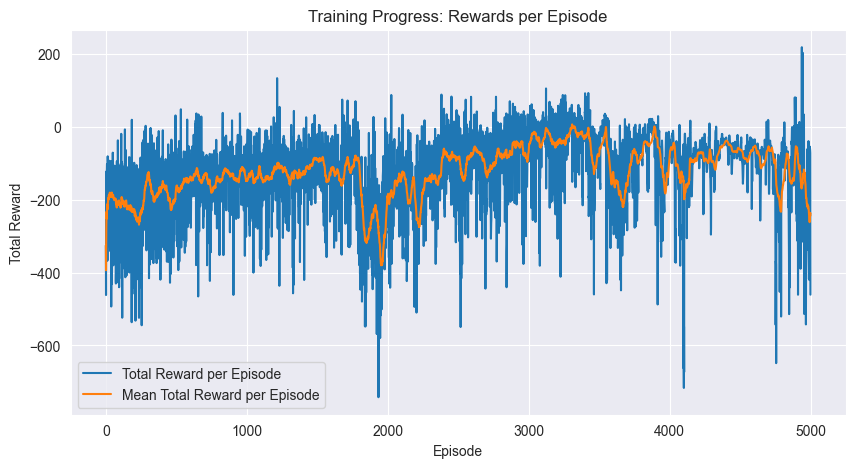

In [ ]:
# Just making otf.function to model.predict
import time

env = gym.make('LunarLander-v2')
input_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation space:", input_shape, "n_actions:", n_actions)

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
env.action_space.seed(42)  # Ensures deterministic action sampling
from collections import deque





# One training step
batch_size = 256
discount_factor = 0.99
replay_buffer = deque(maxlen=200000)


model = Sequential([
    Dense(32, activation='elu',input_shape=input_shape),                #Elu activation function better than Relu for negative values (Relu can have dying neurons)
    Dense(32, activation='elu'),
    Dense(n_actions, activation='linear')
])
inital_weights = model.get_weights()    

# Optimizer and loss
optimizer = Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()


# Defining epsilon_greedy_policy

@tf.function()
def get_Q_values(state):
    return model(state, training=False)

def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    else:
        #Q_values = model.predict(state[np.newaxis],verbose= 0)                 #np.newAxis to transfomr teh state from (4,) to (1,4), which is needed as input shape for teh Neural Model to predict
        #print(state)
        Q_values = get_Q_values(state[np.newaxis])
        return np.argmax(Q_values[0])                               #Q_values[0] to get the Q_values from the first dimension of the array (for teh first row or only row. Q_values [0] has 2 values, one for each possible action.)

# Replay Buffer


def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

# Play one Step, using Epsilon Greedy Policy and store the state, action, reward, next_state and done in the replay buffer
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info



@tf.function  # This will optimize the function into a computational graph for better performance
def optimize_model(states, target_Q_values, actions, n_actions, model, loss_fn, optimizer):
    # One-hot encode the actions taken
    mask = tf.one_hot(actions, n_actions)
    
    # Perform the forward pass and loss calculation
    with tf.GradientTape() as tape:
        # Get Q-values for the current states
        all_Q_values = model(states)
        
        # Select the Q-values corresponding to the taken actions using the mask
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        
        # Compute the loss between target Q-values and predicted Q-values
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    
    # Calculate gradients and apply them
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss


def training_step(batch_size):
    # Sample a batch of experiences
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Get Q-values for the next states using the model
    next_Q_values = get_Q_values(next_states)
    #print(f"Shape of next_Q_values: {next_Q_values.shape}")
    
    # Compute the maximum Q-values for the next states (for target Q-values)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    
    # Calculate the target Q-values based on the Bellman equation
    target_Q_values = rewards + (1 - dones) * discount_factor * max_next_Q_values
    #print(f" Target Q_values: {target_Q_values.shape} = rewards: {rewards.shape} + (1 - dones): {(1 - dones).shape} * discount_factor: {discount_factor} * next_best_Q_values: {max_next_Q_values.shape}")

    #print(f"Shape of Target_nextValues: {target_Q_values.shape}")
    
    # Call the optimization function with the calculated target Q-values
    loss = optimize_model(states, target_Q_values, actions, n_actions, model, loss_fn, optimizer)
    
    




# Reset Gym environment
env = gym.make('LunarLander-v2')
tf.keras.backend.clear_session()
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
env.action_space.seed(42)  # Ensures action selection is deterministic
replay_buffer.clear()
model.set_weights(inital_weights)


episode_rewards = []
mean_rewards = []
best_score = 0

start_time = time.time()
for episode in range(5000):
    obs = env.reset(seed=42)
    total_reward = 0
    if episode > 0:
        epsilon = max(1 - (episode-0) / (4500-0), 0.01)
    else:
        epsilon = 1

    for step in range(500):
        
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        total_reward += reward  # Accumulate reward
        
        if done:
            break
    episode_rewards.append(total_reward)
    mean_r = np.mean(episode_rewards[-40:]if len(episode_rewards)>40 else episode_rewards)
    mean_rewards.append(mean_r)

    if mean_r > best_score:
        best_weights = model.get_weights()
        best_score = mean_r
    if episode > batch_size:
        training_step(batch_size)
    print(f"Episode: {episode},Total Reward: {total_reward}, Mean Reward: {mean_r}, epsilon: {epsilon}")
    
end_time = time.time()
print(f"Training took {end_time - start_time} seconds")
model.set_weights(best_weights)

# Use Seaborn to plot rewards per episode
sns.set_style("darkgrid")  # Set a nice style
plt.figure(figsize=(10, 5))  # Set figure size

sns.lineplot(x=range(len(episode_rewards)), y=episode_rewards, label="Total Reward per Episode")
sns.lineplot(x=range(len(mean_rewards)), y=mean_rewards,  label="Mean Total Reward per Episode")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress: Rewards per Episode")
plt.legend()
plt.show()

In [5]:
# For plotting the animated video
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


#env.seed(41)
state = env.reset()
random.seed(None)  # Reset to default, random state
np.random.seed(None)
tf.random.set_seed(None)

frames = []

for i in range(30):
    total_reward = 0
    state = env.reset()
    for step in range(500):
        action = epsilon_greedy_policy(state)
        state, reward, done, info = env.step(action)
        total_reward += reward
        if done:
            break
        img = env.render(mode="rgb_array")
        frames.append(img)
    print("Total Reward:", total_reward)
#plot_animation(frames)

Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
Total Reward: 500.0
